# Train & Test 데이터 불러오기

각 년도별 DataFrame을 리스트에 append합니다.

리스트 인덱스별로

0: 2017년도 데이터   

1: 2018년도 데이터 

2: 2019년도 데이터 

3: 202년도 데이터 

입니다

In [1]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.seed = 42
DATA_PATH = "../data_0119/"

warnings.filterwarnings(action='ignore')
PATH_2017 = DATA_PATH + "train/KNOW_2017.csv"
PATH_2018 = DATA_PATH + "train/KNOW_2018.csv"
PATH_2019 = DATA_PATH + "train/KNOW_2019.csv"
PATH_2020 = DATA_PATH + "train/KNOW_2020.csv"

paths = [PATH_2017, PATH_2018, PATH_2019, PATH_2020]
know_train = [pd.read_csv(path) for path in paths]

TEST_PATH_2017 = DATA_PATH + "test/KNOW_2017_test.csv"
TEST_PATH_2018 = DATA_PATH + "test/KNOW_2018_test.csv"
TEST_PATH_2019 = DATA_PATH + "test/KNOW_2019_test.csv"
TEST_PATH_2020 = DATA_PATH + "test/KNOW_2020_test.csv"

TEST_PATHs = [TEST_PATH_2017, TEST_PATH_2018, TEST_PATH_2019, TEST_PATH_2020]
know_test = [pd.read_csv(path) for path in TEST_PATHs]

In [2]:
know_train[3]

,idx,saq1_1,saq1_2,saq2_1,saq2_2,saq3_1,saq3_2,saq4_1,saq4_2,saq5_1,...,기계,건축,연구,방법,기술사,구조,기기,향상,ubda_cnt,knowcode
0,27127,4,4,4,4,4,5,4,5,3,...,0,0,0,0,0,0,0,0,0,304003
1,27128,5,6,5,6,4,5,4,5,4,...,0,0,0,0,0,0,0,0,0,221401
2,27129,3,4,3,4,3,4,3,5,3,...,0,0,0,0,0,0,0,0,0,815001
3,27130,4,5,2,3,3,3,4,5,3,...,0,0,0,0,0,0,0,0,0,304003
4,27131,5,6,4,5,3,5,4,4,4,...,0,0,0,0,0,0,0,0,0,140201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8117,35244,4,6,3,5,3,3,1,0,5,...,0,0,0,0,0,0,0,0,0,121105
8118,35245,3,4,4,5,2,4,4,6,1,...,0,0,0,0,0,0,0,0,0,26102
8119,35246,5,6,3,4,3,4,4,5,5,...,0,0,0,0,0,0,0,0,0,31301
8120,35247,5,6,5,5,4,5,3,3,3,...,0,0,0,0,0,0,0,0,0,154105


# 전처리 

`data_0119`는 이미 전처리된 데이터

In [3]:
years = ['2017', '2018', '2019', '2020']
for i in range(4):
    print(f"{2017+i}: {know_train[i].shape}")

2017: (9486, 271)
2018: (9072, 241)
2019: (8555, 251)
2020: (8122, 290)


## 라벨 인코딩

숫자로 변환할 수 있는 컬럼은 라벨 인코딩을 사용하지 않았습니다.

string이나 object컬럼은 라벨인코더를 이용해 변환하였으며 추후 test셋에 사용해야하기 때문에 년도별, 컬럼별로 dictionary를 이용해 저장하였습니다

In [4]:
from sklearn.preprocessing import LabelEncoder
years = ['2017', '2018', '2019', '2020']

year_encoder = {}

for year, df in zip(years, know_train):
    print(year)
    encoders = {}
    
    for col in df.columns:
        if col == 'idx':
            print("HEHE")
            continue
        
        try:
            df[col] = df[col].map(int)
        except:
            encoder = LabelEncoder()
            df[col] = df[col].map(str)
            df[col] = encoder.fit_transform(df[col])
            encoders[col] = encoder
            
            
    year_encoder[year] = encoders

2017
HEHE
2018
HEHE
2019
HEHE
2020
HEHE


In [5]:
# encode test data
years = ['2017', '2018', '2019', '2020']

for year, df in zip(years, know_test):
    print(year)
    encoders = {}
    
    for col in df.columns:
        
        try:
            df[col] = df[col].map(int)
        except:
            encoder = year_encoder[year][col]
            df[col] = df[col].map(str)
            category_map = {category: idx for idx, category in enumerate(encoder.classes_)}
            df[col] = df[col].apply(lambda x: category_map[x] if x in category_map else -1) # train set에서 보지못한 카테고리변수 -1(UNK) 처리
            

2017
2018
2019
2020


# X, y 구분 및 모델 학습

이번 대회에서 맞춰야 할 값은 knowcode입니다.

ID와 knowcode를 제외한 나머지 feature를 X, knowcode를 정답 y로 두어 모델을 학습하였습니다.

베이스라인에서는 의사결정나무와 랜덤포레스트를 선정하였습니다

df.drop(['idx','knowcode', 'description'], axis=1)

In [7]:
train_data = {}
for year, df in zip(years, know_train):
    train_data[year] = {'X': df.drop(['idx','knowcode','description'], axis=1),
                        'y': df['knowcode']}

test_data = {}
for year, df in zip(years, know_test):
    print(year)
    train_columns = train_data[year]['X'].columns
    test_data[year] =  {'X': df[train_columns]} 

2017
2018
2019
2020


In [8]:
for year in years:
    print(year)
    print(f"train: {train_data[year]['X'].shape} test: {test_data[year]['X'].shape}")

2017
train: (9486, 268) test: (9486, 268)
2018
train: (9072, 238) test: (9069, 238)
2019
train: (8555, 248) test: (8554, 248)
2020
train: (8122, 287) test: (8122, 287)


## SMOTE
train data oversampling  
* 모집단이 class 불균형이 심한듯 -> class끼리 균일하게 하지 말고 stratified 방식으로 oversampling 하자

In [9]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

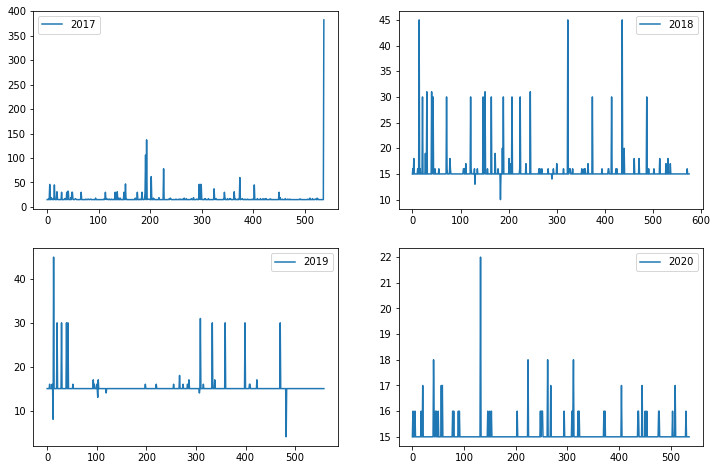

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for year in years:
    if year == '2017': r,c = 0,0
    elif year == '2018': r,c = 0,1
    elif year == '2019': r,c = 1,0
    elif year == '2020': r,c = 1,1
    
    d = train_data[year]['y'].value_counts().sort_index().tolist()
    axes[r, c].plot(d, label=f"{year}")
    axes[r, c].legend()

fig.show()

In [12]:
for year in years:
    print(year)
    for i, v in train_data[year]['y'].value_counts()[:5].items():
        print(i,v)

2017
9999999 382
212101 137
211101 106
301004 78
214301 62
2018
415404 45
13305 45
622304 45
301004 31
22103 31
2019
13305 45
415404 31
24404 30
615203 30
521304 30
2020
140101 22
25401 18
416203 18
240101 18
306903 18


In [13]:
# resampling with SMOTE
train_data_resampled = {}

sample_num_per_year = {
    '2017': 30, 
    '2018': 30,
    '2019': 30,
    '2020': 20
}

for year in years:
    print(f"{year} sampling")
    target_counts = train_data[year]['y'].value_counts()
    resample_dict = {}
    sample_num = sample_num_per_year[year]
    k_neighbors = 6
    for i, num in target_counts.items():
        resample_dict[i] = max(num, sample_num)
        if num < k_neighbors:
            k_neighbors = num-1
            print(f"minimum neighbor size {k_neighbors}")

    smote = SMOTE(sampling_strategy=resample_dict, random_state=RANDOM_STATE,
            k_neighbors=k_neighbors
        )
    X_resampled, y_resampled = smote.fit_resample(train_data[year]['X'], train_data[year]['y'])
    
    train_data_resampled[year] = {
        'X': X_resampled, 'y': y_resampled
    }
    print("done")

2017 sampling
done
2018 sampling
done
2019 sampling
minimum neighbor size 3
done
2020 sampling
done


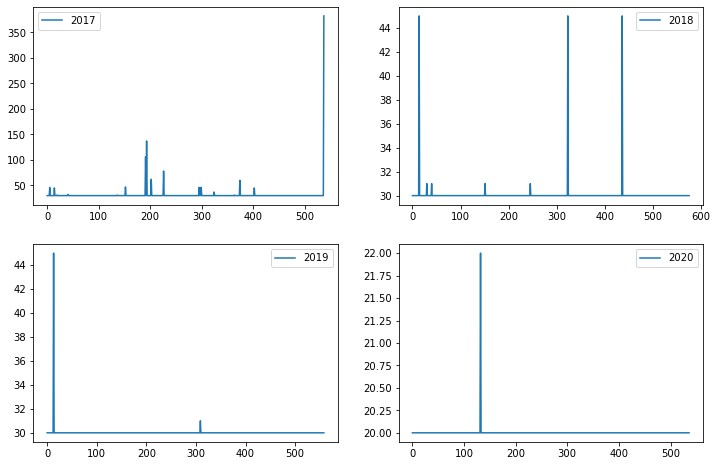

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for year in years:
    if year == '2017': r,c = 0,0
    elif year == '2018': r,c = 0,1
    elif year == '2019': r,c = 1,0
    elif year == '2020': r,c = 1,1
    
    d = train_data_resampled[year]['y'].value_counts().sort_index().tolist()
    axes[r, c].plot(d, label=f"{year}")
    axes[r, c].legend()

fig.show()

In [15]:
for year in years:
    print(year)
    print(
        f"X :{train_data[year]['X'].shape}, y: {train_data[year]['y'].shape} -> X :{train_data_resampled[year]['X'].shape}, y: {train_data_resampled[year]['y'].shape}")

2017
X :(9486, 268), y: (9486,) -> X :(16910, 268), y: (16910,)
2018
X :(9072, 238), y: (9072,) -> X :(17329, 238), y: (17329,)
2019
X :(8555, 248), y: (8555,) -> X :(16786, 248), y: (16786,)
2020
X :(8122, 287), y: (8122,) -> X :(10742, 287), y: (10742,)


In [16]:
train_data_resampled['2017']['X']

,aq1_1,aq1_2,aq2_1,aq2_2,aq3_1,aq3_2,aq4_1,aq4_2,aq5_1,aq5_2,...,시스템,사업,기계,망치,공구,연구,방법,캐드,기기,ubda_cnt
0,3,3,3,3,3,3,4,4,3,4,...,0,0,0,0,0,0,0,0,0,1
1,4,5,4,5,3,4,3,4,3,4,...,0,0,0,0,0,0,0,0,0,0
2,3,4,3,4,3,4,5,6,4,5,...,0,0,0,0,0,0,0,0,0,0
3,3,3,3,3,3,5,4,5,4,6,...,0,0,0,0,0,0,0,0,0,0
4,4,5,3,4,3,4,4,5,3,4,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16905,2,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,1
16906,2,2,1,1,1,1,2,2,2,2,...,0,0,0,0,0,0,0,0,0,1
16907,2,2,2,2,2,2,3,3,2,2,...,0,0,0,0,0,0,0,0,0,1
16908,2,2,2,2,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,1


# Extra Trees Classifier

`n_estimators = 300`

In [21]:
from sklearn.ensemble import ExtraTreesClassifier

et_models = {}
et_predicts = [] 

for year in tqdm(years):
    # train
    model = ExtraTreesClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=8)
    model.fit(train_data_resampled[year]['X'].iloc[:, :], train_data_resampled[year]['y'])

    # predict
    pred = model.predict(test_data[year]['X'])
    et_predicts.extend(pred)

100%|██████████| 4/4 [01:05<00:00, 16.40s/it]


# 제출

In [22]:
submission = pd.read_csv('../data_0103/sample_submission.csv') # sample submission 불러오기

In [23]:
submission['knowcode'] = et_predicts

submission.to_csv('../submission_files/et_300_smote_with_data_0119.csv', index=False)